# Energy production
This notebook calculates the ETLocal keys of the energy production section. 

TODO: add mermaid chart to describe how this notebook is structured (what goes in and what comes out, flows, ...)

## Import modules

In [1]:
import pandas as pd
from pathlib import Path
from IPython.display import Image, display
import importlib


import src.load_data_manager
import src.transform
import src.yaml_calculator
import src.helper
from src.load_data_manager import LoadDataManager
import config.yaml_to_diagram
from config.yaml_to_diagram import create_dependency_diagram

# Reload the modules to ensure latest version is used
importlib.reload(src.transform);
importlib.reload(src.yaml_calculator);
importlib.reload(src.helper);
importlib.reload(src.load_data_manager);
importlib.reload(config.yaml_to_diagram);

## General

Here we configure the notebook so that all contextual information is loaded and present for the other sections.

TODO: define list with ETLocal keys for which to run this notebook

Give this list as optional argument to helper functions so that if False for a key, then it is not updated in the template.

### Parameters

We first specify general parameters to be used throughout this notebook.

In [2]:
# Select the parent data set. Make sure to use the geo ID. It should be existing in the Dataset Manager.
parent = "nl"

# Specify the year and the reference year for the ETM
year = 2023
year_etm = 2019

# Specify the CSV-separator (presumably either "," or ";")
sep=","

# Specify where the dependency graphs are stored
dep_graph_folder = Path("config","etlocal_keys_final_demand_dependency_outputs", "output")

# Specify where the yaml files with calculation rules are stored
yaml_folder = Path("config","yaml_files_for_etlocal_key_calculation")

## Extract and Transform

Here we define helper functions to be called for multiple cells throughout this specific notebook.

## Extract

In this section:
- We *Load* the relevant data from the data/intermediate folder
- We *Combine* the relevant data by merging municipal and national data

This is handled by the **ETLocalDataModule** which provides a unified interface for all data operations.

The module loads the following data sources:
- The ETLocal template (ETLocal_template_empty.csv)
- Klimaatmonitor data - both municipal and national levels with metadata:
  - km_source_data_converted.csv (municipal data)
  - km_meta_data_converted.csv (municipal metadata)
  - km_national_source_data_converted.csv (national data)
  - km_national_meta_data_converted.csv (national metadata)
- Transport research data (transport_research_cleaned.csv)
- Miscellaneous data (miscellaneous_data_analysis.csv)
- ETM query results (etm_query_combined.csv)

The module:
- Combines municipal-level data from different sources
- Combines national-level data from different sources
- Merges the municipal and national datasets into a single DataFrame
- Caches loaded data for improved performance

In [3]:
data_manager = LoadDataManager()
combined_data = data_manager.combine_all_data(
    include_miscellaneous=True,
    include_etm_queries=True,
)
combined_data

#If you want to view etm_queries, uncomment:
# etm_queries = data_manager.load_etm_queries_old()

,Gemeentenaam,ProvinciecodePV,Provincienaam,no_inhabitants,no_residences,no_cars,total_energy_tj,tp_total_energy_tj,total_electricity_tj,total_gas_heat_tj_temp_corrected,...,mq_buildings_final_demand_for_lighting_electricity_buildings_lighting_led_electricity_parent_share,mq_buildings_final_demand_for_cooling_electricity_buildings_cooling_airconditioning_electricity_parent_share,mq_buildings_final_demand_for_cooling_electricity_buildings_cooling_heatpump_air_water_electricity_parent_share,mq_buildings_final_demand_for_cooling_electricity_buildings_cooling_collective_heatpump_water_water_ts_electricity_parent_share,mq_input_percentage_of_lt_steam_hot_water_buildings_final_demand_steam_hot_water,mq_input_percentage_of_mt_steam_hot_water_buildings_final_demand_steam_hot_water,mq_input_percentage_of_ht_steam_hot_water_buildings_final_demand_steam_hot_water,mq_input_percentage_of_lt_steam_hot_water_households_final_demand_steam_hot_water,mq_input_percentage_of_mt_steam_hot_water_households_final_demand_steam_hot_water,mq_input_percentage_of_ht_steam_hot_water_households_final_demand_steam_hot_water
GM0014,Groningen,PV20,Groningen,238147,122715,NaN,15294,4045,3218,8031,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM0034,Almere,PV24,Flevoland,222825,90690,NaN,10680,3869,2654,4289,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM0037,Stadskanaal,PV20,Groningen,32135,15177,NaN,1759,534,409,815,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM0047,Veendam,PV20,Groningen,27616,13013,NaN,0,580,786,0,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM0050,Zeewolde,PV24,Flevoland,23692,9354,NaN,3139,1581,765,794,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1979,Eemsdelta,PV20,Groningen,45394,23587,NaN,0,1049,2026,0,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM1980,Dijk en Waard,PV27,Noord-Holland,88985,37459,NaN,5168,1350,1110,2708,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM1982,Land van Cuijk,PV30,Noord-Brabant,91423,39868,NaN,9022,3179,2073,3769,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0
GM1991,Maashorst,PV30,Noord-Brabant,58934,26012,NaN,4607,1761,1191,1655,...,0.460186,0.918529,0.071604,0.009867,0.0,0.0,1.0,0.0,0.0,1.0


In [4]:
# Load the template
df_template_local = data_manager.load_template(group = 'energy')
df_template_local

unit  \
geo_id group  subgroup               key                                                       
GM1680 energy energy_full_load_hours energy_power_combined_cycle_network_gas_full_lo...  flh   
                                     energy_power_ultra_supercritical_network_gas_fu...  flh   
                                     energy_power_turbine_network_gas_full_load_hours    flh   
                                     energy_power_engine_network_gas_full_load_hours     flh   
                                     energy_power_supercritical_coal_full_load_hours     flh   
...                                                                                      ...   
GM0193 energy energy_biomass         energy_distribution_biogenic_waste_energy_distr...    %   
                                     energy_distribution_non_biogenic_waste_energy_d...    %   
                                     energy_production_dry_biomass_max_demand             TJ   
                                     energy_production_wet_biomass_max_demand             TJ   
                                     energy_production_oily_biomass_max_demand            TJ   

                                                                                         value  \
geo_id group  subgroup               key                                                         
GM1680 energy energy_full_load_hours energy_power_combined_cycle_network_gas_full_lo...    NaN   
                                     energy_power_ultra_supercritical_network_gas_fu...    NaN   
                                     energy_power_turbine_network_gas_full_load_hours      NaN   
                                     energy_power_engine_network_gas_full_load_hours       NaN   
                                     energy_power_supercritical_coal_full_load_hours       NaN   
...                                                                                        ...   
GM0193 energy energy_biomass         energy_distribution_biogenic_waste_energy_distr...    NaN   
                                     energy_distribution_non_biogenic_waste_energy_d...    NaN   
                                     energy_production_dry_biomass_max_demand              NaN   
                                     energy_production_wet_biomass_max_demand              NaN   
                                     energy_production_oily_biomass_max_demand             NaN   

                                                                                        commit  
geo_id group  subgroup               key                                                        
GM1680 energy energy_full_load_hours energy_power_combined_cycle_network_gas_full_lo...    nan  
                                     energy_power_ultra_supercritical_network_gas_fu...    nan  
                                     energy_power_turbine_network_gas_full_load_hours      nan  
                                     energy_power_engine_network_gas_full_load_hours       nan  
                                     energy_power_supercritical_coal_full_load_hours       nan  
...                                                                                        ...  
GM0193 energy energy_biomass         energy_distribution_biogenic_waste_energy_distr...    nan  
                                     energy_distribution_non_biogenic_waste_energy_d...    nan  
                                     energy_production_dry_biomass_max_demand              nan  
                                     energy_production_wet_biomass_max_demand              nan  
                                     energy_production_oily_biomass_max_demand             nan  

[73188 rows x 3 columns]

In this section we import the relevant dataframes from the data/intermediate folder.

## Run YamlCalculator

##### Keys set to zero

Specify which keys

In [5]:
input_keys_zero = [
'input_energy_power_ultra_supercritical_coal_production',
'input_energy_power_supercritical_coal_production',
'input_energy_power_combined_cycle_coal_production',
'input_energy_power_ultra_supercritical_cofiring_coal_production',
'input_energy_power_combined_cycle_ccs_coal_production',
'input_energy_power_ultra_supercritical_ccs_coal_production',
'input_energy_chp_ultra_supercritical_ht_coal_production',
'input_energy_chp_ultra_supercritical_mt_coal_production',
'input_energy_chp_ultra_supercritical_cofiring_ht_coal_production',
'input_energy_chp_ultra_supercritical_cofiring_mt_coal_production',
'input_energy_power_ultra_supercritical_lignite_production',
'input_energy_chp_ultra_supercritical_ht_lignite_production',
'input_energy_chp_ultra_supercritical_mt_lignite_production',
'input_energy_power_ultra_supercritical_oxyfuel_ccs_lignite_production',
'input_energy_power_ultra_supercritical_network_gas_production',
'input_energy_power_turbine_network_gas_production',
'input_energy_power_engine_network_gas_production',
'input_energy_power_combined_cycle_network_gas_production',
'input_energy_power_combined_cycle_ccs_network_gas_production',
'input_energy_chp_combined_cycle_ht_network_gas_production',
'input_energy_chp_combined_cycle_mt_network_gas_production',
'input_energy_chp_local_engine_ht_network_gas_production',
'input_energy_chp_local_engine_mt_network_gas_production',
'input_energy_power_nuclear_gen2_uranium_oxide_production',
'input_energy_power_nuclear_gen3_uranium_oxide_production',
'input_energy_power_ultra_supercritical_crude_oil_production',
'input_energy_power_engine_diesel_production',
'input_energy_heat_burner_mt_wood_pellets_production',
'input_energy_heat_burner_ht_coal_production',
'input_energy_heat_burner_mt_coal_production',
'input_energy_heat_burner_ht_crude_oil_production',
'input_energy_heat_burner_mt_crude_oil_production',
'input_energy_heat_heatpump_water_water_mt_electricity_production',
'input_energy_heat_heatpump_water_water_lt_electricity_production',
'input_energy_heat_boiler_ht_electricity_production',
'input_energy_heat_boiler_mt_electricity_production',
'input_energy_heat_boiler_lt_electricity_production',
'input_energy_heat_well_deep_mt_geothermal_production',
'input_energy_heat_well_shallow_heatpump_mt_geothermal_production',
'input_energy_heat_well_shallow_lt_geothermal_production',
'input_energy_heat_burner_ht_hydrogen_production',
'input_energy_heat_burner_mt_hydrogen_production',
'input_energy_heat_burner_lt_hydrogen_production',
'input_energy_heat_burner_ht_network_gas_production',
'input_energy_heat_burner_mt_network_gas_production',
'input_energy_heat_solar_ht_solar_thermal_production',
'input_energy_heat_solar_mt_solar_thermal_production',
'input_energy_heat_solar_lt_solar_thermal_production',
'input_energy_heat_burner_mt_waste_mix_production',
'energy_heat_import_ht_steam_hot_water_demand',
'energy_heat_import_mt_steam_hot_water_demand',
'energy_heat_import_lt_steam_hot_water_demand',
'input_energy_power_wind_turbine_coastal_production',
'input_energy_power_wind_turbine_offshore_production',
'input_energy_power_solar_csp_solar_radiation_production',
'input_energy_chp_supercritical_ht_waste_mix_production',
'input_energy_chp_supercritical_mt_waste_mix_production',
'input_energy_power_supercritical_ccs_waste_mix_production',
'input_energy_chp_local_ht_wood_pellets_production',
'input_energy_chp_local_mt_wood_pellets_production',
'input_energy_chp_local_engine_mt_biogas_production',
'input_energy_power_geothermal_production',
'energy_regasification_lng_energy_national_gas_network_natural_gas_demand',
'energy_distribution_network_gas_loss_demand',
'input_energy_power_hydro_mountain_production',
'energy_extraction_coal_demand',
'energy_extraction_lignite_demand',
'energy_extraction_crude_oil_demand',
'energy_extraction_natural_gas_demand',
'energy_extraction_uranium_oxide_demand',
'aquathermal_potential_for_surface_water',
'aquathermal_potential_for_waste_water',
'aquathermal_potential_for_drink_water'
]

In [6]:
# data_manager.load_template(group = 'energy')
# etlocal_key = 'energy_distribution_network_gas_loss_demand'
# df_template_local = data_manager.load_template()
# df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)
# df_template_local

In [7]:
# Move later to src.helper
def set_key_to_zero(etlocal_key, df_template_local):
    etlocal_key = etlocal_key
    df_template_local = src.helper.fill_template_with_uniform_value_etlocal_data(etlocal_key, 0, df_template_local)
    return df_template_local

# df_template_local = data_manager.load_template()   
for i in range(len(input_keys_zero)):
    df_template_local = set_key_to_zero(input_keys_zero[i], df_template_local)

In [8]:
df_template_local.loc[(slice(None), slice(None), slice(None), 'energy_distribution_network_gas_loss_demand')]
# df_template_local

,,,unit,value,commit
geo_id,group,subgroup,,,
GM0014,energy,energy_energy_demand,TJ,0.0,No data available. Set to 0 for all municipali...
GM0034,energy,energy_energy_demand,TJ,0.0,No data available. Set to 0 for all municipali...
GM0037,energy,energy_energy_demand,TJ,0.0,No data available. Set to 0 for all municipali...
GM0047,energy,energy_energy_demand,TJ,0.0,No data available. Set to 0 for all municipali...
GM0050,energy,energy_energy_demand,TJ,0.0,No data available. Set to 0 for all municipali...
...,...,...,...,...,...
GM1979,energy,energy_energy_demand,TJ,0.0,No data available. Set to 0 for all municipali...
GM1980,energy,energy_energy_demand,TJ,0.0,No data available. Set to 0 for all municipali...
GM1982,energy,energy_energy_demand,TJ,0.0,No data available. Set to 0 for all municipali...


##### Final demand > HV network loss demand

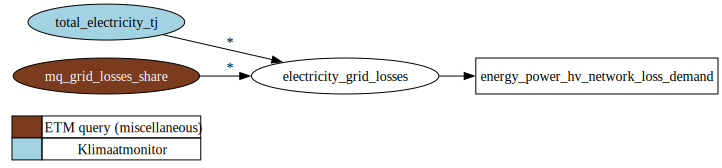

In [9]:
etlocal_key = 'energy_power_hv_network_loss_demand'
# show ETLocal dependency graph

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [10]:
sector = 'energy production'
output_description = 'HV network loss'
arithmic_op= ['add','multiply']
vars_description = ['the final electricity demand including behind-the-meter solar power','share of grid losses']
vars_source = ['Klimaatmonitor','ETM']
message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

HV network loss in the energy production sector is calculated by multiplying the final electricity demand including behind-the-meter solar power (Klimaatmonitor, 2023) by share of grid losses (ETM, 2023).


2. Calculate etlocal_key values and add commit messages

In [11]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

,energy_power_hv_network_loss_demand,electricity_grid_losses,error_message,commit
GM0014,213.259987,213.259987,NaN,HV network loss in the energy production secto...
GM0034,175.883159,175.883159,NaN,HV network loss in the energy production secto...
GM0037,27.104827,27.104827,NaN,HV network loss in the energy production secto...
GM0047,52.088984,52.088984,NaN,HV network loss in the energy production secto...
GM0050,50.697293,50.697293,NaN,HV network loss in the energy production secto...
...,...,...,...,...
GM1979,134.264989,134.264989,NaN,HV network loss in the energy production secto...
GM1980,73.560779,73.560779,NaN,HV network loss in the energy production secto...
GM1982,137.379725,137.379725,NaN,HV network loss in the energy production secto...
GM1991,78.928727,78.928727,NaN,HV network loss in the energy production secto...


3. Add data to template.

In [12]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

,,,unit,value,commit
geo_id,group,subgroup,,,
GM0014,energy,energy_energy_demand,TJ,213.259987,HV network loss in the energy production secto...
GM0034,energy,energy_energy_demand,TJ,175.883159,HV network loss in the energy production secto...
GM0037,energy,energy_energy_demand,TJ,27.104827,HV network loss in the energy production secto...
GM0047,energy,energy_energy_demand,TJ,52.088984,HV network loss in the energy production secto...
GM0050,energy,energy_energy_demand,TJ,50.697293,HV network loss in the energy production secto...
...,...,...,...,...,...
GM1979,energy,energy_energy_demand,TJ,134.264989,HV network loss in the energy production secto...
GM1980,energy,energy_energy_demand,TJ,73.560779,HV network loss in the energy production secto...
GM1982,energy,energy_energy_demand,TJ,137.379725,HV network loss in the energy production secto...


4. Validate data using quick-scan function.

In [13]:
for key, value in src.helper.validate_template_data(df_template_local, etlocal_key).items():
    print(f"{key}: {value}")

key: energy_power_hv_network_loss_demand
total_rows: 342
zero_count: 0
nan_count: 0
min_value: 1.2591484642844435
max_value: 1602.4320982314655
mean_value: 67.59600369099057
median_value: 36.54844095015109


In [14]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: energy_power_hv_network_loss_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  medium_diff: 218 municipalities (64.5%)
  large_diff: 97 municipalities (28.7%)
  small_diff: 23 municipalities (6.8%)

 VALUE STATISTICS:
  Template:     Min=1.26, Max=1602.43, Mean=67.34
  Verification: Min=1.06, Max=1538.44, Mean=65.97
  Abs diff:     Min=0.00, Max=345.35, Mean=8.23

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1979: Template=134.26, Verification=479.62, Diff=345.35 (-72.0%)


/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM1979,134.264989,479.615065,345.350076,-72.005677,large_diff
GM0394,629.242877,446.873011,182.369866,40.810222,large_diff
GM0971,18.887227,190.227597,171.34037,-90.071248,large_diff
GM1883,299.611064,452.226274,152.615211,-33.747533,large_diff
GM1966,345.338034,209.648739,135.689295,64.722209,large_diff
...,...,...,...,...,...
GM0281,52.221526,52.28769,0.066165,-0.126539,small_diff
GM0384,32.207692,32.244076,0.036383,-0.112838,small_diff
GM0088,1.590503,1.556181,0.034322,2.205531,medium_diff
GM0473,12.856569,12.822934,0.033635,0.262303,small_diff


<!-- 


input_energy_chp_local_engine_ht_biogas_production
input_energy_power_hydro_river_production
input_energy_power_hydro_mountain_production -->

##### Final demand > Energy distribution greengas demand

*Note*:
 - In the previous dataset (2019), a different method was used (see `pipelines/config/yaml_files_for_etlocal_key_calculation/energy_distribution_greengas_demand_dependency (old).yaml`).
 - We deviate from that method because, for a few municipalities, the outcome was negative. This was caused by the `total_gas_scaled` variable. Previously, this was calculated using the total gas & heat consumption, minus renewable heat not supplying district heating, and renewable heat supplying district heating. In some cases, the total gas & heat use provided by Klimaatmonitor was unknown and therefore zero (see the old YAML file for details).
 - In the current key, we used gas demand from the built environment (`gas_gotj`), agriculture (`gas_a_tj`), and industry (`gas_bcdef`), as reported by Klimaatmonitor. We calculated their shares relative to the (national) totals. These shares are provided as the `share_gas_demand` input.
 - However, it appears that the gas demand figures for industry are not accurate. Therefore, in the future, we should base this on the total gas use of the built environment, agriculture, and industry, as calculated in the national dataset.

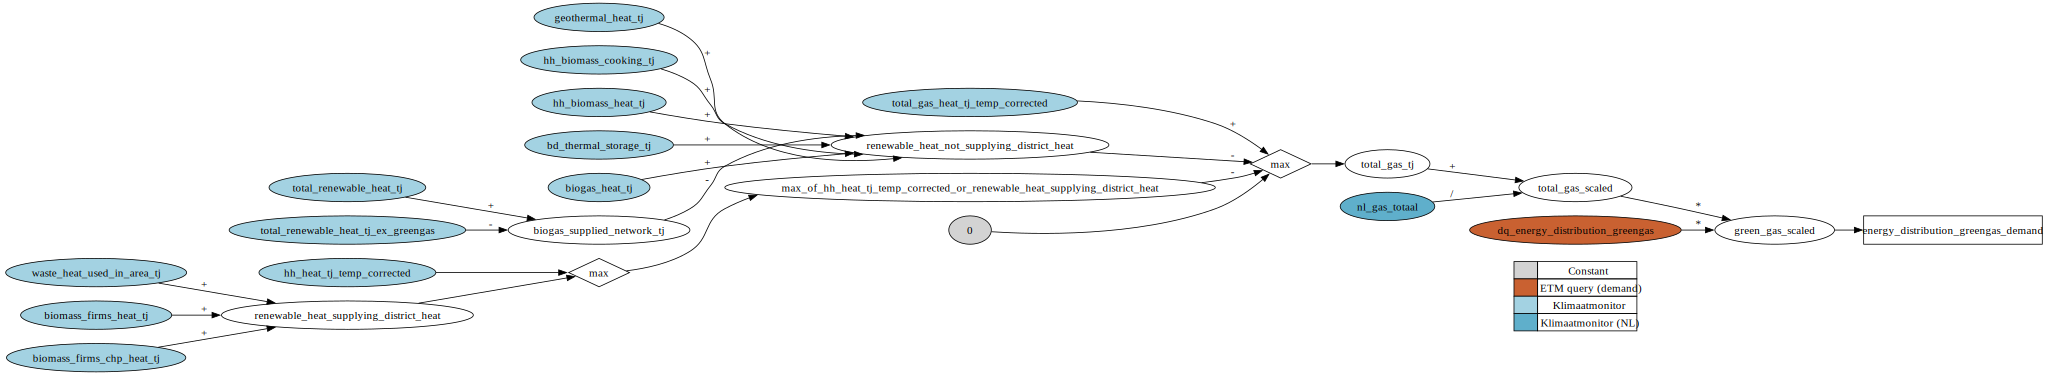

In [15]:
etlocal_key = 'energy_distribution_greengas_demand'
# show ETLocal dependency graph

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Read the information for the commit message from the image and write them down to generate the commit message.

In [16]:
sector = 'energy production'
output_description = 'Green gas production'
arithmic_op= ['add','multiply']
vars_description = ['the final gas demand','the share of green gas production']
vars_source = ['Klimaatmonitor','ETM']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Green gas production in the energy production sector is calculated by multiplying the final gas demand (Klimaatmonitor, 2023) by the share of green gas production (ETM, 2023).


2. Calculate etlocal_key values

In [17]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

,energy_distribution_greengas_demand,biogas_supplied_network_tj,renewable_heat_not_supplying_district_heat,renewable_heat_supplying_district_heat,max_of_hh_heat_tj_temp_corrected_or_renewable_heat_supplying_district_heat,total_gas_tj,total_gas_scaled,green_gas_scaled,error_message,commit
GM0014,121.506736,0.0,318.0,7.0,99.0,7614.0,0.010289,121.506736,NaN,Green gas production in the energy production ...
GM0034,36.911621,0.0,463.0,27.0,1513.0,2313.0,0.003126,36.911621,NaN,Green gas production in the energy production ...
GM0037,11.777249,0.0,62.0,15.0,15.0,738.0,0.000997,11.777249,NaN,Green gas production in the energy production ...
GM0047,0.000000,0.0,54.0,0.0,0.0,0.0,0.000000,0.000000,NaN,Green gas production in the energy production ...
GM0050,11.330415,0.0,29.0,6.0,55.0,710.0,0.000959,11.330415,NaN,Green gas production in the energy production ...
...,...,...,...,...,...,...,...,...,...,...
GM1979,0.000000,0.0,96.0,3982.0,3982.0,0.0,0.000000,0.000000,NaN,Green gas production in the energy production ...
GM1980,40.007537,0.0,103.0,0.0,98.0,2507.0,0.003388,40.007537,NaN,Green gas production in the energy production ...
GM1982,51.784786,6.0,193.0,331.0,331.0,3245.0,0.004385,51.784786,NaN,Green gas production in the energy production ...
GM1991,23.969414,0.0,83.0,70.0,70.0,1502.0,0.002030,23.969414,NaN,Green gas production in the energy production ...


3. Add data to template.

In [18]:
# # df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group  subgroup                                key                                                       
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    %   
                                                      energy_distribution_non_biogenic_waste_energy_d...    %   
                                                      energy_greengas_gasification_dry_biomass_energy...    %   
                                                      energy_greengas_gasification_wet_biomass_energy...    %   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    %   
...                                                                                                       ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...   TJ   
                                                      input_energy_power_supercritical_waste_mix_prod...   TJ   
                                                      input_energy_power_wind_turbine_coastal_production   TJ   
                                                      input_energy_power_wind_turbine_inland_production    TJ   
                                                      input_energy_power_wind_turbine_offshore_produc...   TJ   

                                                                                                          value  \
geo_id group  subgroup                                key                                                         
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    NaN   
                                                      energy_distribution_non_biogenic_waste_energy_d...    NaN   
                                                      energy_greengas_gasification_dry_biomass_energy...    NaN   
                                                      energy_greengas_gasification_wet_biomass_energy...    NaN   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    NaN   
...                                                                                                         ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...    0.0   
                                                      input_energy_power_supercritical_waste_mix_prod...    NaN   
                                                      input_energy_power_wind_turbine_coastal_production    0.0   
                                                      input_energy_power_wind_turbine_inland_production     NaN   
                                                      input_energy_power_wind_turbine_offshore_produc...    0.0   

                                                                                                                                                     commit  
geo_id group  subgroup                                key                                                                                                    
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...                                                nan  
                                                      energy_distribution_non_biogenic_waste_energy_d...                                                nan  
                                                      energy_greengas_gasification_dry_biomass_energy...                                                nan  
                                                      energy_greengas_gasification_wet_biomass_energy...                                                nan  
                                                      energy_greengas_upgrade_biogas_energy_greengas_...                                                nan  
...                              

4. Validate data using quick-scan function.

In [19]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'energy_distribution_greengas_demand',
 'total_rows': 342,
 'zero_count': 23,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 1598.7056523594385,
 'mean_value': 27.864646699515937,
 'median_value': 12.774644387240276}

In [20]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: energy_distribution_greengas_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=1598.71, Mean=27.67
  Verification: Min=0.39, Max=852.93, Mean=17.49
  Abs diff:     Min=0.24, Max=745.78, Mean=16.69

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=1598.71, Verification=852.93, Diff=745.78 (87.4%)
  Municipality GM1883: Template=0.00, Verification=283.77, Diff=283.77 (-100.0%

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM0599,1598.705652,852.930487,745.775166,87.436805,large_diff
GM1883,0.000000,283.767514,283.767514,-100.000000,large_diff
GM0715,0.000000,266.606716,266.606716,-100.000000,large_diff
GM1783,399.357246,200.220448,199.136799,99.458772,large_diff
GM0363,346.040461,151.455302,194.585159,128.476955,large_diff
...,...,...,...,...,...
GM0589,2.920375,1.717841,1.202533,70.002569,large_diff
GM0339,1.627750,0.944496,0.683254,72.340596,large_diff
GM0096,0.861750,0.488095,0.373655,76.553658,large_diff
GM0088,0.845792,0.481756,0.364035,75.564201,large_diff


##### Final demand > Power sector own use electricity demand

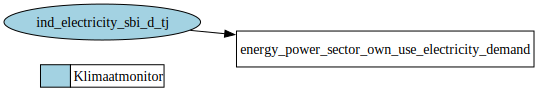

In [21]:
# Define ETLocal key
etlocal_key = "energy_power_sector_own_use_electricity_demand"
# show ETLocal dependency graph

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [22]:
sector = 'energy production'
output_description = 'Electricity demand'
arithmic_op = None
vars_description = None
vars_source = ['Klimaatmonitor']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Electricity demand in the energy production sector is directly retrieved from Klimaatmonitor (2023).


2. Calculate etlocal_key values and add commit messages

In [23]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

,energy_power_sector_own_use_electricity_demand,error_message,commit
GM0014,20.3832,NaN,Electricity demand in the energy production se...
GM0034,37.7064,NaN,Electricity demand in the energy production se...
GM0037,0.4464,NaN,Electricity demand in the energy production se...
GM0047,13.9896,NaN,Electricity demand in the energy production se...
GM0050,9.4500,NaN,Electricity demand in the energy production se...
...,...,...,...
GM1979,227.0448,NaN,Electricity demand in the energy production se...
GM1980,0.9756,NaN,Electricity demand in the energy production se...
GM1982,9.8208,NaN,Electricity demand in the energy production se...
GM1991,0.4032,NaN,Electricity demand in the energy production se...


3. Add data to template

In [24]:
# df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group  subgroup                                key                                                       
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    %   
                                                      energy_distribution_non_biogenic_waste_energy_d...    %   
                                                      energy_greengas_gasification_dry_biomass_energy...    %   
                                                      energy_greengas_gasification_wet_biomass_energy...    %   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    %   
...                                                                                                       ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...   TJ   
                                                      input_energy_power_supercritical_waste_mix_prod...   TJ   
                                                      input_energy_power_wind_turbine_coastal_production   TJ   
                                                      input_energy_power_wind_turbine_inland_production    TJ   
                                                      input_energy_power_wind_turbine_offshore_produc...   TJ   

                                                                                                          value  \
geo_id group  subgroup                                key                                                         
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    NaN   
                                                      energy_distribution_non_biogenic_waste_energy_d...    NaN   
                                                      energy_greengas_gasification_dry_biomass_energy...    NaN   
                                                      energy_greengas_gasification_wet_biomass_energy...    NaN   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    NaN   
...                                                                                                         ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...    0.0   
                                                      input_energy_power_supercritical_waste_mix_prod...    NaN   
                                                      input_energy_power_wind_turbine_coastal_production    0.0   
                                                      input_energy_power_wind_turbine_inland_production     NaN   
                                                      input_energy_power_wind_turbine_offshore_produc...    0.0   

                                                                                                                                                     commit  
geo_id group  subgroup                                key                                                                                                    
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...                                                nan  
                                                      energy_distribution_non_biogenic_waste_energy_d...                                                nan  
                                                      energy_greengas_gasification_dry_biomass_energy...                                                nan  
                                                      energy_greengas_gasification_wet_biomass_energy...                                                nan  
                                                      energy_greengas_upgrade_biogas_energy_greengas_...                                                nan  
...                              

4. Use validation function to quick-scan data

In [25]:
for key, value in src.helper.validate_template_data(df_template_local, etlocal_key).items():
    print(f"{key}: {value}")

key: energy_power_sector_own_use_electricity_demand
total_rows: 342
zero_count: 62
nan_count: 0
min_value: 0.0
max_value: 1343.2068
mean_value: 12.884273684210525
median_value: 0.6479999999999999


In [26]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: energy_power_sector_own_use_electricity_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 188 municipalities (55.6%)
  exact_match: 63 municipalities (18.6%)
  small_diff: 56 municipalities (16.6%)
  medium_diff: 31 municipalities (9.2%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=1343.21, Mean=13.00
  Verification: Min=0.00, Max=739.41, Mean=9.10
  Abs diff:     Min=0.00, Max=603.80, Mean=8.14

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template=

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM0599,1343.2068,739.4076,603.7992,81.659859,large_diff
GM1966,496.7676,0,496.7676,0.000000,small_diff
GM0779,76.6620,505.0008,428.3388,-84.819430,large_diff
GM1979,227.0448,0,227.0448,0.000000,small_diff
GM1952,187.9488,0,187.9488,0.000000,small_diff
...,...,...,...,...,...
GM0406,0.0000,0,0.0,0.000000,exact_match
GM1724,0.0000,0,0.0,0.000000,exact_match
GM1723,0.0000,0,0.0,0.000000,exact_match
GM1721,0.0000,0,0.0,0.000000,exact_match


##### Waste mix

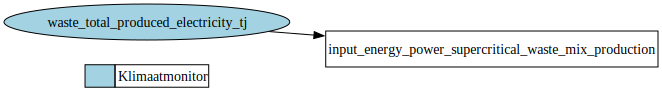

In [27]:
# Define ETLocal key
etlocal_key = "input_energy_power_supercritical_waste_mix_production"
# show ETLocal dependency graph

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Read the information for the commit message from the image and write them down to generate the commit message.

In [28]:
meta = data_manager.get_metadata()
# meta.loc['waste_total_produced_electricity_tj']
print(meta.loc['waste_total_produced_electricity_tj', ['Onderwerp']].iloc[0])

Opgewekte elektriciteit afvalverbranding (AVI, fossiele en biogene oorsprong, GWh)


In [29]:
sector = 'energy production'
output_description = 'Electricity generated from waste incineration (AVI, fossil and biogenic origin)'
arithmic_op= None
vars_description = None
vars_source = ['Klimaatmonitor']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Electricity generated from waste incineration (AVI, fossil and biogenic origin) in the energy production sector is directly retrieved from Klimaatmonitor (2023).


Describe output key for the commit message by describing the last step:

In [30]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

,input_energy_power_supercritical_waste_mix_production,error_message,commit
GM0014,0.0,NaN,Electricity generated from waste incineration ...
GM0034,0.0,NaN,Electricity generated from waste incineration ...
GM0037,0.0,NaN,Electricity generated from waste incineration ...
GM0047,0.0,NaN,Electricity generated from waste incineration ...
GM0050,0.0,NaN,Electricity generated from waste incineration ...
...,...,...,...
GM1979,673.2,NaN,Electricity generated from waste incineration ...
GM1980,0.0,NaN,Electricity generated from waste incineration ...
GM1982,0.0,NaN,Electricity generated from waste incineration ...
GM1991,0.0,NaN,Electricity generated from waste incineration ...


3. Add data to template

In [31]:
# # df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group  subgroup                                key                                                       
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    %   
                                                      energy_distribution_non_biogenic_waste_energy_d...    %   
                                                      energy_greengas_gasification_dry_biomass_energy...    %   
                                                      energy_greengas_gasification_wet_biomass_energy...    %   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    %   
...                                                                                                       ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...   TJ   
                                                      input_energy_power_supercritical_waste_mix_prod...   TJ   
                                                      input_energy_power_wind_turbine_coastal_production   TJ   
                                                      input_energy_power_wind_turbine_inland_production    TJ   
                                                      input_energy_power_wind_turbine_offshore_produc...   TJ   

                                                                                                          value  \
geo_id group  subgroup                                key                                                         
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    NaN   
                                                      energy_distribution_non_biogenic_waste_energy_d...    NaN   
                                                      energy_greengas_gasification_dry_biomass_energy...    NaN   
                                                      energy_greengas_gasification_wet_biomass_energy...    NaN   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    NaN   
...                                                                                                         ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...    0.0   
                                                      input_energy_power_supercritical_waste_mix_prod...    0.0   
                                                      input_energy_power_wind_turbine_coastal_production    0.0   
                                                      input_energy_power_wind_turbine_inland_production     NaN   
                                                      input_energy_power_wind_turbine_offshore_produc...    0.0   

                                                                                                                                                     commit  
geo_id group  subgroup                                key                                                                                                    
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...                                                nan  
                                                      energy_distribution_non_biogenic_waste_energy_d...                                                nan  
                                                      energy_greengas_gasification_dry_biomass_energy...                                                nan  
                                                      energy_greengas_gasification_wet_biomass_energy...                                                nan  
                                                      energy_greengas_upgrade_biogas_energy_greengas_...                                                nan  
...                              

4. Validate data using quick-scan function.

In [32]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_energy_power_supercritical_waste_mix_production',
 'total_rows': 342,
 'zero_count': 331,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 2800.8,
 'mean_value': 38.61052631578948,
 'median_value': 0.0}

In [33]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_energy_power_supercritical_waste_mix_production
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 326 municipalities (96.4%)
  medium_diff: 6 municipalities (1.8%)
  large_diff: 6 municipalities (1.8%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=2800.80, Mean=39.07
  Verification: Min=0.00, Max=2595.60, Mean=42.70
  Abs diff:     Min=0.00, Max=936.00, Mean=9.17

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0363: Template=2800.80, Verification=1864.80, Dif

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM0363,2800.8,1864.8,936.0,50.193050,large_diff
GM0599,1083.6,1692,608.4,-35.957447,large_diff
GM0505,0.0,460.8,460.8,-100.000000,large_diff
GM1731,1018.8,1432.8,414.0,-28.894472,large_diff
GM1709,2304.0,2595.6,291.6,-11.234397,large_diff
...,...,...,...,...,...
GM0392,0.0,0,0.0,0.000000,exact_match
GM0388,0.0,0,0.0,0.000000,exact_match
GM0385,0.0,0,0.0,0.000000,exact_match
GM0384,0.0,0,0.0,0.000000,exact_match


##### Solar PV plant

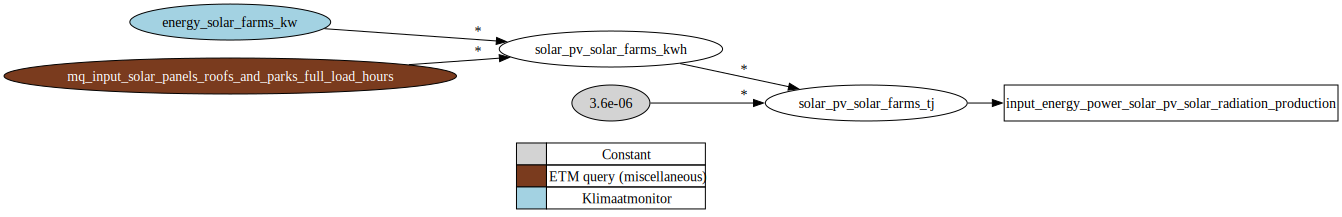

In [34]:
# Define ETLocal key
etlocal_key = "input_energy_power_solar_pv_solar_radiation_production"
# show ETLocal dependency graph

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [35]:
sector = 'energy'
output_description = 'Renewable electricity generation from solar PV farms'
arithmic_op = ['add', 'multiply']
vars_description = ['capacity of field- and water-based solar PV installations','their full load hours']
vars_source = ['Klimaatmonitor','ETM']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

# message = 'empty'

Renewable electricity generation from solar PV farms in the energy sector is calculated by multiplying capacity of field- and water-based solar PV installations (Klimaatmonitor, 2023) by their full load hours (ETM, 2023).


2. Calculate etlocal_key values

In [36]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

,input_energy_power_solar_pv_solar_radiation_production,solar_pv_solar_farms_kwh,solar_pv_solar_farms_tj,error_message,commit
GM0014,241.110,66975000.0,241.110,NaN,Renewable electricity generation from solar PV...
GM0034,169.632,47120000.0,169.632,NaN,Renewable electricity generation from solar PV...
GM0037,513.684,142690000.0,513.684,NaN,Renewable electricity generation from solar PV...
GM0047,89.604,24890000.0,89.604,NaN,Renewable electricity generation from solar PV...
GM0050,180.234,50065000.0,180.234,NaN,Renewable electricity generation from solar PV...
...,...,...,...,...,...
GM1979,250.002,69445000.0,250.002,NaN,Renewable electricity generation from solar PV...
GM1980,32.148,8930000.0,32.148,NaN,Renewable electricity generation from solar PV...
GM1982,100.548,27930000.0,100.548,NaN,Renewable electricity generation from solar PV...
GM1991,42.066,11685000.0,42.066,NaN,Renewable electricity generation from solar PV...


3. Add data to template

In [37]:
# df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]

,,,unit,value,commit
geo_id,group,subgroup,,,
GM0014,energy,energy_renewable_electricity_production,TJ,241.110,Renewable electricity generation from solar PV...
GM0034,energy,energy_renewable_electricity_production,TJ,169.632,Renewable electricity generation from solar PV...
GM0037,energy,energy_renewable_electricity_production,TJ,513.684,Renewable electricity generation from solar PV...
GM0047,energy,energy_renewable_electricity_production,TJ,89.604,Renewable electricity generation from solar PV...
GM0050,energy,energy_renewable_electricity_production,TJ,180.234,Renewable electricity generation from solar PV...
...,...,...,...,...,...
GM1979,energy,energy_renewable_electricity_production,TJ,250.002,Renewable electricity generation from solar PV...
GM1980,energy,energy_renewable_electricity_production,TJ,32.148,Renewable electricity generation from solar PV...
GM1982,energy,energy_renewable_electricity_production,TJ,100.548,Renewable electricity generation from solar PV...


4. Validate data using quick-scan function

In [38]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_energy_power_solar_pv_solar_radiation_production',
 'total_rows': 342,
 'zero_count': 123,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 978.12,
 'mean_value': 51.679,
 'median_value': 4.616999999999999}

In [39]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_energy_power_solar_pv_solar_radiation_production
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  small_diff: 125 municipalities (37.0%)
  exact_match: 123 municipalities (36.4%)
  large_diff: 80 municipalities (23.7%)
  medium_diff: 10 municipalities (3.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=978.12, Mean=51.62
  Verification: Min=0.00, Max=229.47, Mean=7.20
  Abs diff:     Min=0.00, Max=978.12, Mean=44.43

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1681: 

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM1681,978.120,0,978.12,0.000000,small_diff
GM0303,759.582,5.24,754.342,14395.839695,large_diff
GM1952,870.048,171.42,698.628,407.553378,large_diff
GM0715,615.258,5.51,609.748,11066.206897,large_diff
GM0995,665.190,67.97,597.22,878.652347,large_diff
...,...,...,...,...,...
GM0880,0.000,0,0.0,0.000000,exact_match
GM0888,0.000,0,0.0,0.000000,exact_match
GM0397,0.000,0,0.0,0.000000,exact_match
GM0893,0.000,0,0.0,0.000000,exact_match


##### Wind turbine inland

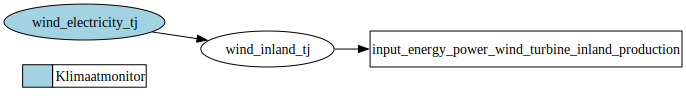

In [40]:
# Define ETLocal key
etlocal_key = "input_energy_power_wind_turbine_inland_production"
# show ETLocal dependency graph

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [41]:
meta = data_manager.get_metadata()
# meta.loc['waste_total_produced_electricity_tj']
print(meta.loc['wind_electricity_tj', ['Onderwerp']].iloc[0])

Wind op land hern. elektriciteit genormaliseerd


In [42]:
sector = 'energy production'
output_description = 'Renewable electricity generation from wind turbines (onshore)'
arithmic_op = None
vars_description = None
vars_source = ['Klimaatmonitor']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Renewable electricity generation from wind turbines (onshore) in the energy production sector is directly retrieved from Klimaatmonitor (2023).


In [43]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

,input_energy_power_wind_turbine_inland_production,error_message,commit
GM0014,0.0,NaN,Renewable electricity generation from wind tur...
GM0034,595.0,NaN,Renewable electricity generation from wind tur...
GM0037,0.0,NaN,Renewable electricity generation from wind tur...
GM0047,337.0,NaN,Renewable electricity generation from wind tur...
GM0050,4414.0,NaN,Renewable electricity generation from wind tur...
...,...,...,...
GM1979,2573.0,NaN,Renewable electricity generation from wind tur...
GM1980,59.0,NaN,Renewable electricity generation from wind tur...
GM1982,0.0,NaN,Renewable electricity generation from wind tur...
GM1991,0.0,NaN,Renewable electricity generation from wind tur...


In [44]:
# meta = data_manager.get_metadata()
klimaatmonitor = data_manager.load_klimaatmonitor_data()['km_data']
klimaatmonitor['wind_electricity_tj']

GemeenteCode
GM1680    631
GM0358      0
GM0197    115
GM0059      4
GM0482      0
         ... 
GM0879    284
GM0301     25
GM1896      0
GM0642      0
GM0193     58
Name: wind_electricity_tj, Length: 342, dtype: int64

3. Add data to template

In [45]:
# df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group  subgroup                                key                                                       
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    %   
                                                      energy_distribution_non_biogenic_waste_energy_d...    %   
                                                      energy_greengas_gasification_dry_biomass_energy...    %   
                                                      energy_greengas_gasification_wet_biomass_energy...    %   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    %   
...                                                                                                       ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...   TJ   
                                                      input_energy_power_supercritical_waste_mix_prod...   TJ   
                                                      input_energy_power_wind_turbine_coastal_production   TJ   
                                                      input_energy_power_wind_turbine_inland_production    TJ   
                                                      input_energy_power_wind_turbine_offshore_produc...   TJ   

                                                                                                          value  \
geo_id group  subgroup                                key                                                         
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    NaN   
                                                      energy_distribution_non_biogenic_waste_energy_d...    NaN   
                                                      energy_greengas_gasification_dry_biomass_energy...    NaN   
                                                      energy_greengas_gasification_wet_biomass_energy...    NaN   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    NaN   
...                                                                                                         ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...    0.0   
                                                      input_energy_power_supercritical_waste_mix_prod...    0.0   
                                                      input_energy_power_wind_turbine_coastal_production    0.0   
                                                      input_energy_power_wind_turbine_inland_production    19.0   
                                                      input_energy_power_wind_turbine_offshore_produc...    0.0   

                                                                                                                                                     commit  
geo_id group  subgroup                                key                                                                                                    
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...                                                nan  
                                                      energy_distribution_non_biogenic_waste_energy_d...                                                nan  
                                                      energy_greengas_gasification_dry_biomass_energy...                                                nan  
                                                      energy_greengas_gasification_wet_biomass_energy...                                                nan  
                                                      energy_greengas_upgrade_biogas_energy_greengas_...                                                nan  
...                              

4. Validate data using quick-scan function.

In [46]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_energy_power_wind_turbine_inland_production',
 'total_rows': 342,
 'zero_count': 220,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 5409.0,
 'mean_value': 165.9766081871345,
 'median_value': 0.0}

In [47]:
verification_results = src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_energy_power_wind_turbine_inland_production
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 227 municipalities (67.2%)
  large_diff: 62 municipalities (18.3%)
  medium_diff: 32 municipalities (9.5%)
  small_diff: 17 municipalities (5.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=5409.00, Mean=167.71
  Verification: Min=0.00, Max=3649.00, Mean=78.89
  Abs diff:     Min=0.00, Max=4740.00, Mean=95.50

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1900: Te

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


##### Heat burner HT waste

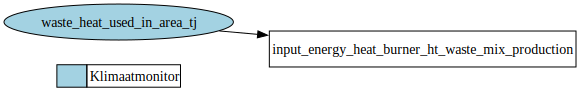

In [49]:
etlocal_key = 'input_energy_heat_burner_ht_waste_mix_production'
# show ETLocal dependency graph

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [50]:
meta = data_manager.get_metadata()
# meta.loc['waste_total_produced_electricity_tj']
print(meta.loc['waste_heat_used_in_area_tj', ['Onderwerp']].iloc[0])

Doorgeleverde warmte afvalverbranding (AVI, fossiele en biogene oorsprong)


In [51]:
# meta = data_manager.get_metadata()
# # meta.loc['waste_total_produced_electricity_tj']
# print(meta.loc['waste_heat_used_in_area_tj', ['Onderwerp']].iloc[0])

sector = 'energy production'
output_description = 'Supplied heat from waste incineration (AVI, fossil and biogenic origin)'
arithmic_op= None
vars_description = None
vars_source = ['Klimaatmonitor']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Supplied heat from waste incineration (AVI, fossil and biogenic origin) in the energy production sector is directly retrieved from Klimaatmonitor (2023).


2. Calculate etlocal_key values and add commit messages

In [52]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

,input_energy_heat_burner_ht_waste_mix_production,error_message,commit
GM0014,0.0,NaN,"Supplied heat from waste incineration (AVI, fo..."
GM0034,0.0,NaN,"Supplied heat from waste incineration (AVI, fo..."
GM0037,0.0,NaN,"Supplied heat from waste incineration (AVI, fo..."
GM0047,0.0,NaN,"Supplied heat from waste incineration (AVI, fo..."
GM0050,0.0,NaN,"Supplied heat from waste incineration (AVI, fo..."
...,...,...,...
GM1979,2776.0,NaN,"Supplied heat from waste incineration (AVI, fo..."
GM1980,0.0,NaN,"Supplied heat from waste incineration (AVI, fo..."
GM1982,0.0,NaN,"Supplied heat from waste incineration (AVI, fo..."
GM1991,0.0,NaN,"Supplied heat from waste incineration (AVI, fo..."


In [53]:
# meta = data_manager.get_metadata()
klimaatmonitor = data_manager.load_klimaatmonitor_data()['km_data']
klimaatmonitor['waste_heat_used_in_area_tj']

GemeenteCode
GM1680    0
GM0358    0
GM0197    0
GM0059    0
GM0482    0
         ..
GM0879    0
GM0301    0
GM1896    0
GM0642    0
GM0193    0
Name: waste_heat_used_in_area_tj, Length: 342, dtype: int64

3. Add data to template.

In [54]:
# df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group  subgroup                                key                                                       
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    %   
                                                      energy_distribution_non_biogenic_waste_energy_d...    %   
                                                      energy_greengas_gasification_dry_biomass_energy...    %   
                                                      energy_greengas_gasification_wet_biomass_energy...    %   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    %   
...                                                                                                       ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...   TJ   
                                                      input_energy_power_supercritical_waste_mix_prod...   TJ   
                                                      input_energy_power_wind_turbine_coastal_production   TJ   
                                                      input_energy_power_wind_turbine_inland_production    TJ   
                                                      input_energy_power_wind_turbine_offshore_produc...   TJ   

                                                                                                          value  \
geo_id group  subgroup                                key                                                         
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    NaN   
                                                      energy_distribution_non_biogenic_waste_energy_d...    NaN   
                                                      energy_greengas_gasification_dry_biomass_energy...    NaN   
                                                      energy_greengas_gasification_wet_biomass_energy...    NaN   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    NaN   
...                                                                                                         ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...    0.0   
                                                      input_energy_power_supercritical_waste_mix_prod...    0.0   
                                                      input_energy_power_wind_turbine_coastal_production    0.0   
                                                      input_energy_power_wind_turbine_inland_production    19.0   
                                                      input_energy_power_wind_turbine_offshore_produc...    0.0   

                                                                                                                                                     commit  
geo_id group  subgroup                                key                                                                                                    
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...                                                nan  
                                                      energy_distribution_non_biogenic_waste_energy_d...                                                nan  
                                                      energy_greengas_gasification_dry_biomass_energy...                                                nan  
                                                      energy_greengas_gasification_wet_biomass_energy...                                                nan  
                                                      energy_greengas_upgrade_biogas_energy_greengas_...                                                nan  
...                              

4. Validate data using quick-scan function.

In [55]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_energy_heat_burner_ht_waste_mix_production',
 'total_rows': 342,
 'zero_count': 330,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 3171.0,
 'mean_value': 46.51754385964912,
 'median_value': 0.0}

In [56]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_energy_heat_burner_ht_waste_mix_production
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 326 municipalities (96.4%)
  large_diff: 10 municipalities (3.0%)
  small_diff: 1 municipalities (0.3%)
  medium_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=3171.00, Mean=47.07
  Verification: Min=0.00, Max=4101.00, Mean=46.59
  Abs diff:     Min=0.00, Max=930.00, Mean=11.97

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0599: Template

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM0599,3171.0,4101,930.0,-22.677396,large_diff
GM0505,93.0,943,850.0,-90.137858,large_diff
GM1709,2672.0,2002,670.0,33.466533,large_diff
GM0072,1860.0,1470,390.0,26.530612,large_diff
GM1731,378.0,91,287.0,315.384615,large_diff
...,...,...,...,...,...
GM0392,0.0,0,0.0,0.000000,exact_match
GM0388,0.0,0,0.0,0.000000,exact_match
GM0385,0.0,0,0.0,0.000000,exact_match
GM0384,0.0,0,0.0,0.000000,exact_match


##### Deep geothermal heater (HT)

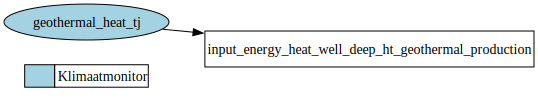

In [57]:
etlocal_key = 'input_energy_heat_well_deep_ht_geothermal_production'
# show ETLocal dependency graph

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [58]:
key = 'geothermal_heat_tj'
meta = data_manager.get_metadata()
meta.loc[key]
print(meta.loc[key, ['Onderwerp']].iloc[0])

Aardwarmte (diepe bodemenergie)


In [59]:
# key = 'agri_electricity_tj'
# meta = data_manager.get_metadata()
# meta.loc[key]
# print(meta.loc[key, ['Onderwerp']].iloc[0])

sector = 'energy production'
output_description = 'Geothermal heat production from deep geothermal wells'
arithmic_op= None
vars_description = None
vars_source = ['Klimaatmonitor']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Geothermal heat production from deep geothermal wells in the energy production sector is directly retrieved from Klimaatmonitor (2023).


2. Calculate etlocal_key values and add commit messages

In [60]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

,input_energy_heat_well_deep_ht_geothermal_production,error_message,commit
GM0014,0.0,NaN,Geothermal heat production from deep geotherma...
GM0034,0.0,NaN,Geothermal heat production from deep geotherma...
GM0037,0.0,NaN,Geothermal heat production from deep geotherma...
GM0047,0.0,NaN,Geothermal heat production from deep geotherma...
GM0050,0.0,NaN,Geothermal heat production from deep geotherma...
...,...,...,...
GM1979,0.0,NaN,Geothermal heat production from deep geotherma...
GM1980,0.0,NaN,Geothermal heat production from deep geotherma...
GM1982,0.0,NaN,Geothermal heat production from deep geotherma...
GM1991,0.0,NaN,Geothermal heat production from deep geotherma...


In [61]:
# meta = data_manager.get_metadata()
klimaatmonitor = data_manager.load_klimaatmonitor_data()['km_data']
klimaatmonitor['geothermal_heat_tj']

GemeenteCode
GM1680    0
GM0358    0
GM0197    0
GM0059    0
GM0482    0
         ..
GM0879    0
GM0301    0
GM1896    0
GM0642    0
GM0193    0
Name: geothermal_heat_tj, Length: 342, dtype: int64

3. Add data to template.

In [62]:
# df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group  subgroup                                key                                                       
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    %   
                                                      energy_distribution_non_biogenic_waste_energy_d...    %   
                                                      energy_greengas_gasification_dry_biomass_energy...    %   
                                                      energy_greengas_gasification_wet_biomass_energy...    %   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    %   
...                                                                                                       ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...   TJ   
                                                      input_energy_power_supercritical_waste_mix_prod...   TJ   
                                                      input_energy_power_wind_turbine_coastal_production   TJ   
                                                      input_energy_power_wind_turbine_inland_production    TJ   
                                                      input_energy_power_wind_turbine_offshore_produc...   TJ   

                                                                                                          value  \
geo_id group  subgroup                                key                                                         
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    NaN   
                                                      energy_distribution_non_biogenic_waste_energy_d...    NaN   
                                                      energy_greengas_gasification_dry_biomass_energy...    NaN   
                                                      energy_greengas_gasification_wet_biomass_energy...    NaN   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    NaN   
...                                                                                                         ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...    0.0   
                                                      input_energy_power_supercritical_waste_mix_prod...    0.0   
                                                      input_energy_power_wind_turbine_coastal_production    0.0   
                                                      input_energy_power_wind_turbine_inland_production    19.0   
                                                      input_energy_power_wind_turbine_offshore_produc...    0.0   

                                                                                                                                                     commit  
geo_id group  subgroup                                key                                                                                                    
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...                                                nan  
                                                      energy_distribution_non_biogenic_waste_energy_d...                                                nan  
                                                      energy_greengas_gasification_dry_biomass_energy...                                                nan  
                                                      energy_greengas_gasification_wet_biomass_energy...                                                nan  
                                                      energy_greengas_upgrade_biogas_energy_greengas_...                                                nan  
...                              

4. Validate data using quick-scan function.

In [63]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_energy_heat_well_deep_ht_geothermal_production',
 'total_rows': 342,
 'zero_count': 331,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 1311.0,
 'mean_value': 19.099415204678362,
 'median_value': 0.0}

In [64]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_energy_heat_well_deep_ht_geothermal_production
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 328 municipalities (97.0%)
  large_diff: 8 municipalities (2.4%)
  small_diff: 1 municipalities (0.3%)
  medium_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=1311.00, Mean=17.72
  Verification: Min=0.00, Max=1549.00, Mean=15.54
  Abs diff:     Min=0.00, Max=668.00, Mean=6.16

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0171: Templa

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM0171,883.0,215,668.0,310.697674,large_diff
GM1926,596.0,292,304.0,104.109589,large_diff
GM0396,109.0,401,292.0,-72.817955,large_diff
GM0420,803.0,561,242.0,43.137255,large_diff
GM1783,1311.0,1549,238.0,-15.364751,large_diff
...,...,...,...,...,...
GM0384,0.0,0,0.0,0.000000,exact_match
GM0383,0.0,0,0.0,0.000000,exact_match
GM0377,0.0,0,0.0,0.000000,exact_match
GM0376,0.0,0,0.0,0.000000,exact_match


##### Heatpump water ht 

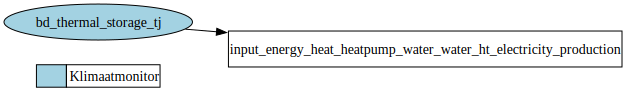

In [65]:
# Define ETLocal key
etlocal_key = "input_energy_heat_heatpump_water_water_ht_electricity_production"
# show ETLocal dependency graph

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [66]:
key = 'bd_thermal_storage_tj'
meta = data_manager.get_metadata()
meta.loc[key]
print(meta.loc[key, ['Onderwerp']].iloc[0])

Ondiepe bodemenergie hern. energie (WKO/WP)


In [67]:
# key = 'bd_thermal_storage_tj'
# meta = data_manager.get_metadata()
# meta.loc[key]
# print(meta.loc[key, ['Onderwerp']].iloc[0])

sector = 'energy production'
output_description = 'Geothermal electricity production from shallow geothermal wells'
arithmic_op= None
vars_description = None
vars_source = ['Klimaatmonitor']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)

Geothermal electricity production from shallow geothermal wells in the energy production sector is directly retrieved from Klimaatmonitor (2023).


In [68]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

,input_energy_heat_heatpump_water_water_ht_electricity_production,error_message,commit
GM0014,144.0,NaN,Geothermal electricity production from shallow...
GM0034,342.0,NaN,Geothermal electricity production from shallow...
GM0037,1.0,NaN,Geothermal electricity production from shallow...
GM0047,1.0,NaN,Geothermal electricity production from shallow...
GM0050,4.0,NaN,Geothermal electricity production from shallow...
...,...,...,...
GM1979,3.0,NaN,Geothermal electricity production from shallow...
GM1980,19.0,NaN,Geothermal electricity production from shallow...
GM1982,19.0,NaN,Geothermal electricity production from shallow...
GM1991,8.0,NaN,Geothermal electricity production from shallow...


3. Add data to template

In [69]:
# df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group  subgroup                                key                                                       
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    %   
                                                      energy_distribution_non_biogenic_waste_energy_d...    %   
                                                      energy_greengas_gasification_dry_biomass_energy...    %   
                                                      energy_greengas_gasification_wet_biomass_energy...    %   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    %   
...                                                                                                       ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...   TJ   
                                                      input_energy_power_supercritical_waste_mix_prod...   TJ   
                                                      input_energy_power_wind_turbine_coastal_production   TJ   
                                                      input_energy_power_wind_turbine_inland_production    TJ   
                                                      input_energy_power_wind_turbine_offshore_produc...   TJ   

                                                                                                          value  \
geo_id group  subgroup                                key                                                         
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    NaN   
                                                      energy_distribution_non_biogenic_waste_energy_d...    NaN   
                                                      energy_greengas_gasification_dry_biomass_energy...    NaN   
                                                      energy_greengas_gasification_wet_biomass_energy...    NaN   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    NaN   
...                                                                                                         ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...    0.0   
                                                      input_energy_power_supercritical_waste_mix_prod...    0.0   
                                                      input_energy_power_wind_turbine_coastal_production    0.0   
                                                      input_energy_power_wind_turbine_inland_production    19.0   
                                                      input_energy_power_wind_turbine_offshore_produc...    0.0   

                                                                                                                                                     commit  
geo_id group  subgroup                                key                                                                                                    
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...                                                nan  
                                                      energy_distribution_non_biogenic_waste_energy_d...                                                nan  
                                                      energy_greengas_gasification_dry_biomass_energy...                                                nan  
                                                      energy_greengas_gasification_wet_biomass_energy...                                                nan  
                                                      energy_greengas_upgrade_biogas_energy_greengas_...                                                nan  
...                              

4. Validate data using quick-scan function.

In [70]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'input_energy_heat_heatpump_water_water_ht_electricity_production',
 'total_rows': 342,
 'zero_count': 85,
 'nan_count': 0,
 'min_value': 0.0,
 'max_value': 504.0,
 'mean_value': 19.453216374269005,
 'median_value': 3.5}

In [71]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_energy_heat_heatpump_water_water_ht_electricity_production
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  large_diff: 215 municipalities (63.6%)
  exact_match: 109 municipalities (32.2%)
  small_diff: 13 municipalities (3.8%)
  medium_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=504.00, Mean=19.50
  Verification: Min=0.00, Max=739.00, Mean=13.72
  Abs diff:     Min=0.00, Max=504.00, Mean=10.86

 TOP 10 LARGEST DIFFERENCES:
  Municipality

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM1911,504.0,0,504.0,0.000000,small_diff
GM0363,400.0,739,339.0,-45.872801,large_diff
GM0034,342.0,17,325.0,1911.764706,large_diff
GM0420,299.0,0,299.0,0.000000,small_diff
GM0344,395.0,186,209.0,112.365591,large_diff
...,...,...,...,...,...
GM0946,1.0,1,0.0,0.000000,exact_match
GM0944,0.0,0,0.0,0.000000,exact_match
GM0938,0.0,0,0.0,0.000000,exact_match
GM0417,0.0,0,0.0,0.000000,exact_match


##### District heating sources > Biomass-fired heater (HT)

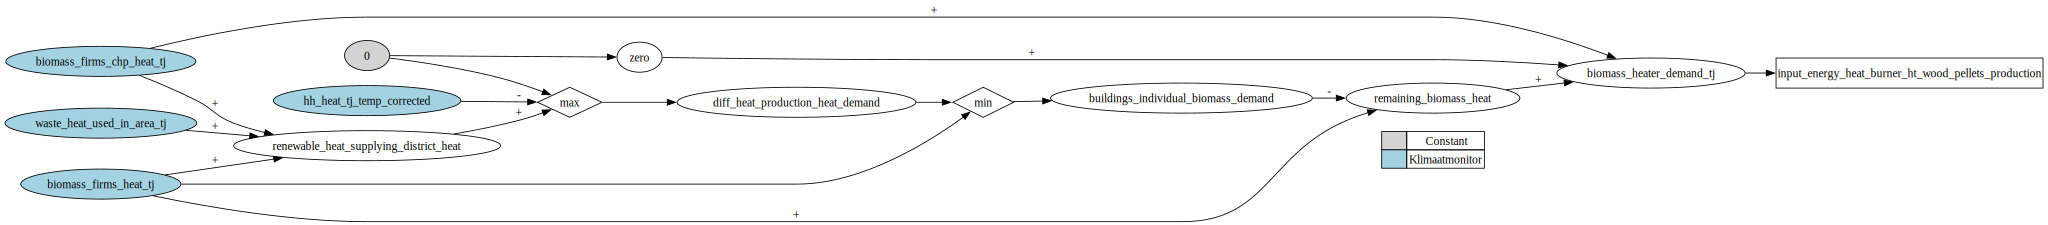

In [72]:
# Define ETLocal key
etlocal_key = "input_energy_heat_burner_ht_wood_pellets_production"
# show ETLocal dependency graph

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [73]:
key = 'biomass_firms_heat_tj'
meta = data_manager.get_metadata()
meta.loc[key]
print(meta.loc[key, ['Onderwerp']].iloc[0])

Biomassaketels bedrijven hern. warmte


In [74]:
message = 'Biomass heat production is calculated by adding CHP heat from biomass firms (Klimaatmonitor, 2023) and the remaining biomass heat, which is determined by subtracting the share of biomass heat used in individual buildings from the total biomass heat supplied to district heating (Klimaatmonitor, 2023).'

print(message)

Biomass heat production is calculated by adding CHP heat from biomass firms (Klimaatmonitor, 2023) and the remaining biomass heat, which is determined by subtracting the share of biomass heat used in individual buildings from the total biomass heat supplied to district heating (Klimaatmonitor, 2023).


2. Calculate etlocal_key values and add commit messages

In [75]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

,input_energy_heat_burner_ht_wood_pellets_production,renewable_heat_supplying_district_heat,diff_heat_production_heat_demand,buildings_individual_biomass_demand,remaining_biomass_heat,biomass_heater_demand_tj,error_message,commit
GM0014,7.0,7.0,0.0,0.0,7.0,7.0,NaN,Biomass heat production is calculated by addin...
GM0034,27.0,27.0,0.0,0.0,27.0,27.0,NaN,Biomass heat production is calculated by addin...
GM0037,15.0,15.0,14.0,0.0,0.0,15.0,NaN,Biomass heat production is calculated by addin...
GM0047,0.0,0.0,0.0,0.0,0.0,0.0,NaN,Biomass heat production is calculated by addin...
GM0050,6.0,6.0,0.0,0.0,1.0,6.0,NaN,Biomass heat production is calculated by addin...
...,...,...,...,...,...,...,...,...
GM1979,1205.0,3982.0,3982.0,1.0,0.0,1205.0,NaN,Biomass heat production is calculated by addin...
GM1980,0.0,0.0,0.0,0.0,0.0,0.0,NaN,Biomass heat production is calculated by addin...
GM1982,315.0,331.0,327.0,16.0,0.0,315.0,NaN,Biomass heat production is calculated by addin...
GM1991,8.0,70.0,70.0,62.0,0.0,8.0,NaN,Biomass heat production is calculated by addin...


3. Add data to template

In [76]:
# df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group  subgroup                                key                                                       
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    %   
                                                      energy_distribution_non_biogenic_waste_energy_d...    %   
                                                      energy_greengas_gasification_dry_biomass_energy...    %   
                                                      energy_greengas_gasification_wet_biomass_energy...    %   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    %   
...                                                                                                       ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...   TJ   
                                                      input_energy_power_supercritical_waste_mix_prod...   TJ   
                                                      input_energy_power_wind_turbine_coastal_production   TJ   
                                                      input_energy_power_wind_turbine_inland_production    TJ   
                                                      input_energy_power_wind_turbine_offshore_produc...   TJ   

                                                                                                          value  \
geo_id group  subgroup                                key                                                         
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    NaN   
                                                      energy_distribution_non_biogenic_waste_energy_d...    NaN   
                                                      energy_greengas_gasification_dry_biomass_energy...    NaN   
                                                      energy_greengas_gasification_wet_biomass_energy...    NaN   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    NaN   
...                                                                                                         ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...    0.0   
                                                      input_energy_power_supercritical_waste_mix_prod...    0.0   
                                                      input_energy_power_wind_turbine_coastal_production    0.0   
                                                      input_energy_power_wind_turbine_inland_production    19.0   
                                                      input_energy_power_wind_turbine_offshore_produc...    0.0   

                                                                                                                                                     commit  
geo_id group  subgroup                                key                                                                                                    
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...                                                nan  
                                                      energy_distribution_non_biogenic_waste_energy_d...                                                nan  
                                                      energy_greengas_gasification_dry_biomass_energy...                                                nan  
                                                      energy_greengas_gasification_wet_biomass_energy...                                                nan  
                                                      energy_greengas_upgrade_biogas_energy_greengas_...                                                nan  
...                              

4. Validate data using quick-scan function.

In [77]:
for key, value in src.helper.validate_template_data(df_template_local, etlocal_key).items():
    print(f"{key}: {value}")

key: input_energy_heat_burner_ht_wood_pellets_production
total_rows: 342
zero_count: 221
nan_count: 0
min_value: 0.0
max_value: 1205.0
mean_value: 29.204678362573098
median_value: 0.0


In [78]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_energy_heat_burner_ht_wood_pellets_production
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 214 municipalities (63.3%)
  large_diff: 80 municipalities (23.7%)
  small_diff: 37 municipalities (10.9%)
  medium_diff: 7 municipalities (2.1%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=1205.00, Mean=28.59
  Verification: Min=0.00, Max=1619.00, Mean=36.44
  Abs diff:     Min=0.00, Max=1000.00, Mean=25.31

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1709: T

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM1709,86.0,1086,1000.0,-92.081031,large_diff
GM0344,1102.0,212,890.0,419.811321,large_diff
GM0505,45.0,726,681.0,-93.801653,large_diff
GM0164,676.0,1277,601.0,-47.063430,large_diff
GM0772,278.0,758,480.0,-63.324538,large_diff
...,...,...,...,...,...
GM0678,0.0,0,0.0,0.000000,exact_match
GM0687,0.0,0,0.0,0.000000,exact_match
GM0158,0.0,0,0.0,0.000000,exact_match
GM0716,0.0,0,0.0,0.000000,exact_match


##### CHP local engine HT biogas production

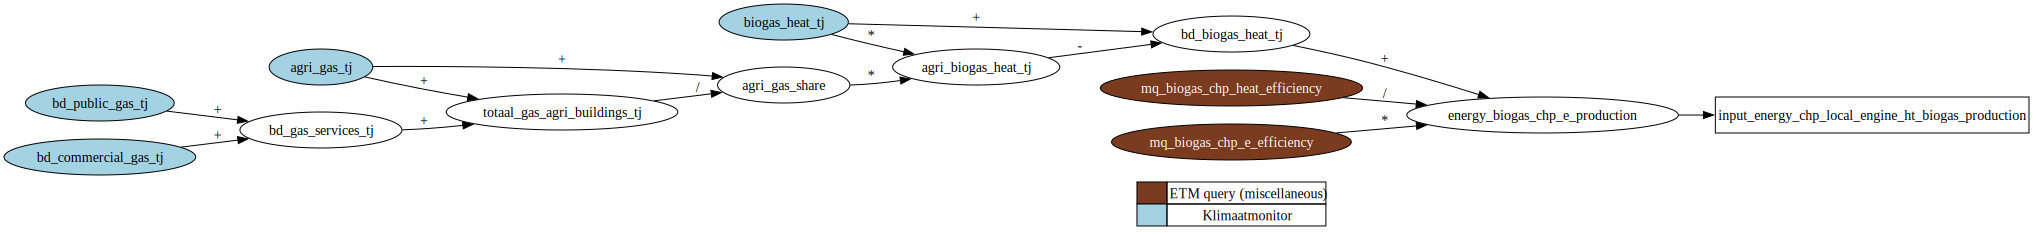

In [79]:
# Define ETLocal key
etlocal_key = "input_energy_chp_local_engine_ht_biogas_production"
# show ETLocal dependency graph

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit message by describing the last step:

In [80]:
key = 'bd_public_gas_tj'
meta = data_manager.get_metadata()
meta.loc[key]
print(meta.loc[key, ['Onderwerp']].iloc[0])


Aardgasverbruik Publieke Dienstverlening


In [81]:
message = 'Electricity production from biogas CHP is calculated by taking the total biogas heat production in agriculture and commercial buildings (Klimaatmonitor, 2023), determining the agricultural share of total biogas heat production based on gas consumption in agriculture and commercial buildings (Klimaatmonitor 2023), and then converting the resulting biogas demand for heat production to electricity production in biogas CHP’s using their typical efficiency (ETM, 2023).'

print(message)

Electricity production from biogas CHP is calculated by taking the total biogas heat production in agriculture and commercial buildings (Klimaatmonitor, 2023), determining the agricultural share of total biogas heat production based on gas consumption in agriculture and commercial buildings (Klimaatmonitor 2023), and then converting the resulting biogas demand for heat production to electricity production in biogas CHP’s using their typical efficiency (ETM, 2023).


In [82]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

,input_energy_chp_local_engine_ht_biogas_production,bd_gas_services_tj,totaal_gas_agri_buildings_tj,agri_gas_share,agri_biogas_heat_tj,bd_biogas_heat_tj,energy_biogas_chp_e_production,error_message,commit
GM0014,71.191990,1574.290212,1600.717962,0.016510,0.842007,50.157993,71.191990,NaN,Electricity production from biogas CHP is calc...
GM0034,0.000000,244.512771,567.121221,0.568853,0.000000,0.000000,0.000000,NaN,Electricity production from biogas CHP is calc...
GM0037,0.000000,147.978341,159.467291,0.072046,0.000000,0.000000,0.000000,NaN,Electricity production from biogas CHP is calc...
GM0047,9.397263,142.571919,150.737619,0.054172,0.379201,6.620799,9.397263,NaN,Electricity production from biogas CHP is calc...
GM0050,0.000000,188.402354,408.021704,0.538254,0.000000,0.000000,0.000000,NaN,Electricity production from biogas CHP is calc...
...,...,...,...,...,...,...,...,...,...
GM1979,0.000000,277.920296,317.767646,0.125398,0.000000,0.000000,0.000000,NaN,Electricity production from biogas CHP is calc...
GM1980,0.000000,229.665123,1014.268623,0.773566,0.000000,0.000000,0.000000,NaN,Electricity production from biogas CHP is calc...
GM1982,10.424989,408.633150,945.796950,0.567948,9.655122,7.344878,10.424989,NaN,Electricity production from biogas CHP is calc...
GM1991,0.000000,340.870500,409.107900,0.166796,0.000000,0.000000,0.000000,NaN,Electricity production from biogas CHP is calc...


In [83]:
# meta = data_manager.get_metadata()
klimaatmonitor = data_manager.load_klimaatmonitor_data()['km_data']
klimaatmonitor['biogas_heat_tj']

GemeenteCode
GM1680     0
GM0358     0
GM0197     0
GM0059     0
GM0482     0
          ..
GM0879     0
GM0301     0
GM1896     0
GM0642     0
GM0193    26
Name: biogas_heat_tj, Length: 342, dtype: int64

3. Add data to template

In [84]:
# df_template_local = data_manager.load_template()|
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group  subgroup                                key                                                       
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    %   
                                                      energy_distribution_non_biogenic_waste_energy_d...    %   
                                                      energy_greengas_gasification_dry_biomass_energy...    %   
                                                      energy_greengas_gasification_wet_biomass_energy...    %   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    %   
...                                                                                                       ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...   TJ   
                                                      input_energy_power_supercritical_waste_mix_prod...   TJ   
                                                      input_energy_power_wind_turbine_coastal_production   TJ   
                                                      input_energy_power_wind_turbine_inland_production    TJ   
                                                      input_energy_power_wind_turbine_offshore_produc...   TJ   

                                                                                                          value  \
geo_id group  subgroup                                key                                                         
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    NaN   
                                                      energy_distribution_non_biogenic_waste_energy_d...    NaN   
                                                      energy_greengas_gasification_dry_biomass_energy...    NaN   
                                                      energy_greengas_gasification_wet_biomass_energy...    NaN   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    NaN   
...                                                                                                         ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...    0.0   
                                                      input_energy_power_supercritical_waste_mix_prod...    0.0   
                                                      input_energy_power_wind_turbine_coastal_production    0.0   
                                                      input_energy_power_wind_turbine_inland_production    19.0   
                                                      input_energy_power_wind_turbine_offshore_produc...    0.0   

                                                                                                                                                     commit  
geo_id group  subgroup                                key                                                                                                    
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...                                                nan  
                                                      energy_distribution_non_biogenic_waste_energy_d...                                                nan  
                                                      energy_greengas_gasification_dry_biomass_energy...                                                nan  
                                                      energy_greengas_gasification_wet_biomass_energy...                                                nan  
                                                      energy_greengas_upgrade_biogas_energy_greengas_...                                                nan  
...                              

4. Use validation function to quick-scan data

In [85]:
for key, value in src.helper.validate_template_data(df_template_local, etlocal_key).items():
    print(f"{key}: {value}")

key: input_energy_chp_local_engine_ht_biogas_production
total_rows: 342
zero_count: 276
nan_count: 0
min_value: 0.0
max_value: 189.88355952734688
mean_value: 4.41628734897465
median_value: 0.0


In [86]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_energy_chp_local_engine_ht_biogas_production
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 264 municipalities (78.1%)
  large_diff: 52 municipalities (15.4%)
  small_diff: 16 municipalities (4.7%)
  medium_diff: 6 municipalities (1.8%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=189.88, Mean=4.44
  Verification: Min=0.00, Max=91.54, Mean=3.44
  Abs diff:     Min=0.00, Max=98.35, Mean=2.81

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0363: Template=18

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM0363,189.883560,91.538462,98.345098,107.435821,large_diff
GM1842,4.396120,77.538462,73.142341,-94.330401,large_diff
GM0200,25.014930,88.687322,63.672393,-71.794244,large_diff
GM0209,56.566943,0,56.566943,0.000000,small_diff
GM0855,111.273186,54.925031,56.348156,102.591031,large_diff
...,...,...,...,...,...
GM0523,0.000000,0,0.0,0.000000,exact_match
GM0531,0.000000,0,0.0,0.000000,exact_match
GM0532,0.000000,0,0.0,0.000000,exact_match
GM0534,0.000000,0,0.0,0.000000,exact_match


##### Hydro river power

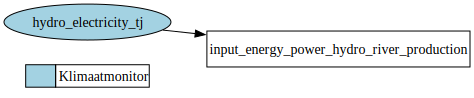

In [87]:
# Define ETLocal key
etlocal_key = "input_energy_power_hydro_river_production"
# show ETLocal dependency graph

# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

Describe output key for the commit messages by describing the last step:

In [88]:
sector = 'energy production'
output_description = 'Electricity production from run-of-river hydro power plants'
arithmic_op = None
vars_description = None
vars_source = ['Klimaatmonitor']

message = src.helper.generate_commit_message_v2(output_description,arithmic_op,vars_description,sector,year,vars_source)
print(message)


Electricity production from run-of-river hydro power plants in the energy production sector is directly retrieved from Klimaatmonitor (2023).


In [89]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key, df_input_vars=combined_data)
df_pipeline['commit'] = message
df_pipeline

,input_energy_power_hydro_river_production,error_message,commit
GM0014,0.0,NaN,Electricity production from run-of-river hydro...
GM0034,0.0,NaN,Electricity production from run-of-river hydro...
GM0037,0.0,NaN,Electricity production from run-of-river hydro...
GM0047,0.0,NaN,Electricity production from run-of-river hydro...
GM0050,0.0,NaN,Electricity production from run-of-river hydro...
...,...,...,...
GM1979,0.0,NaN,Electricity production from run-of-river hydro...
GM1980,0.0,NaN,Electricity production from run-of-river hydro...
GM1982,0.0,NaN,Electricity production from run-of-river hydro...
GM1991,0.0,NaN,Electricity production from run-of-river hydro...


In [90]:
# meta = data_manager.get_metadata()
klimaatmonitor = data_manager.load_klimaatmonitor_data()['km_data']
klimaatmonitor['hydro_electricity_tj']

GemeenteCode
GM1680    0
GM0358    0
GM0197    0
GM0059    0
GM0482    0
         ..
GM0879    0
GM0301    0
GM1896    0
GM0642    0
GM0193    0
Name: hydro_electricity_tj, Length: 342, dtype: int64

3. Add data to template

In [91]:
# df_template_local = data_manager.load_template()
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_template_local

unit  \
geo_id group  subgroup                                key                                                       
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    %   
                                                      energy_distribution_non_biogenic_waste_energy_d...    %   
                                                      energy_greengas_gasification_dry_biomass_energy...    %   
                                                      energy_greengas_gasification_wet_biomass_energy...    %   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    %   
...                                                                                                       ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...   TJ   
                                                      input_energy_power_supercritical_waste_mix_prod...   TJ   
                                                      input_energy_power_wind_turbine_coastal_production   TJ   
                                                      input_energy_power_wind_turbine_inland_production    TJ   
                                                      input_energy_power_wind_turbine_offshore_produc...   TJ   

                                                                                                          value  \
geo_id group  subgroup                                key                                                         
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...    NaN   
                                                      energy_distribution_non_biogenic_waste_energy_d...    NaN   
                                                      energy_greengas_gasification_dry_biomass_energy...    NaN   
                                                      energy_greengas_gasification_wet_biomass_energy...    NaN   
                                                      energy_greengas_upgrade_biogas_energy_greengas_...    NaN   
...                                                                                                         ...   
GM1992 energy energy_renewable_electricity_production input_energy_power_supercritical_ccs_waste_mix_...    0.0   
                                                      input_energy_power_supercritical_waste_mix_prod...    0.0   
                                                      input_energy_power_wind_turbine_coastal_production    0.0   
                                                      input_energy_power_wind_turbine_inland_production    19.0   
                                                      input_energy_power_wind_turbine_offshore_produc...    0.0   

                                                                                                                                                     commit  
geo_id group  subgroup                                key                                                                                                    
GM0014 energy energy_biomass                          energy_distribution_biogenic_waste_energy_distr...                                                nan  
                                                      energy_distribution_non_biogenic_waste_energy_d...                                                nan  
                                                      energy_greengas_gasification_dry_biomass_energy...                                                nan  
                                                      energy_greengas_gasification_wet_biomass_energy...                                                nan  
                                                      energy_greengas_upgrade_biogas_energy_greengas_...                                                nan  
...                              

4. Use validation function to quick-scan data

In [92]:
for key, value in src.helper.validate_template_data(df_template_local, etlocal_key).items():
    print(f"{key}: {value}")

key: input_energy_power_hydro_river_production
total_rows: 342
zero_count: 334
nan_count: 0
min_value: 0.0
max_value: 90.0
mean_value: 0.8888888888888888
median_value: 0.0


In [93]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: input_energy_power_hydro_river_production
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 332 municipalities (98.2%)
  medium_diff: 4 municipalities (1.2%)
  small_diff: 1 municipalities (0.3%)
  large_diff: 1 municipalities (0.3%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=90.00, Mean=0.90
  Verification: Min=0.00, Max=101.00, Mean=0.99
  Abs diff:     Min=0.00, Max=11.00, Mean=0.11

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM1641: Template=90.00, Verific

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  / comparison["verification_value"].replace(0, float("inf"))
/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM1641,90.0,101,11.0,-10.891089,large_diff
GM0214,82.0,91,9.0,-9.890110,medium_diff
GM0828,58.0,64,6.0,-9.375000,medium_diff
GM0668,58.0,64,6.0,-9.375000,medium_diff
GM0855,3.0,0,3.0,0.000000,small_diff
...,...,...,...,...,...
GM0384,0.0,0,0.0,0.000000,exact_match
GM0383,0.0,0,0.0,0.000000,exact_match
GM0377,0.0,0,0.0,0.000000,exact_match
GM0376,0.0,0,0.0,0.000000,exact_match


### Dry biomass max demand

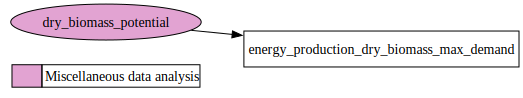

In [94]:
etlocal_key = 'energy_production_dry_biomass_max_demand'
# Create and display the dependency diagram
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram



In [95]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=combined_data)

In [96]:
message = "Production and potentials for bio-resources have been estimated based on research by TNO for the Netherlands (2020). The total production and potential for the Netherlands is subdivided by municipalities and provinces based on various distribution keys. See https://refman.energytransitionmodel.com/publications/2100 for more information."
print(message)
df_pipeline['commit'] = message

Production and potentials for bio-resources have been estimated based on research by TNO for the Netherlands (2020). The total production and potential for the Netherlands is subdivided by municipalities and provinces based on various distribution keys. See https://refman.energytransitionmodel.com/publications/2100 for more information.


Add data to template

In [97]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
df_pipeline[etlocal_key] = df_pipeline[etlocal_key]*100
df_pipeline[etlocal_key]

GM0014    53.728880
GM0034    61.069085
GM0037    15.903103
GM0047    10.868918
GM0050    21.913422
            ...    
GM1979    35.862880
GM1980     7.447959
GM1982    10.765012
GM1991    16.800113
GM1992    14.250526
Name: energy_production_dry_biomass_max_demand, Length: 342, dtype: float64

Use validation function to quick-scan data

In [98]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'energy_production_dry_biomass_max_demand',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 0.005906615,
 'max_value': 2.194338857,
 'mean_value': 0.1785045245760234,
 'median_value': 0.13184370550000002}

In [99]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: energy_production_dry_biomass_max_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.01, Max=2.19, Mean=0.18
  Verification: Min=0.01, Max=2.19, Mean=0.18
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.54, Verification=0.54, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.59, Verification=0.59, Diff=0.00 (0.0%)
  Municipality GM

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM0014,0.537289,0.537289,0.0,0.0,exact_match
GM0855,0.590961,0.590961,0.0,0.0,exact_match
GM0880,0.048549,0.048549,0.0,0.0,exact_match
GM0879,0.131171,0.131171,0.0,0.0,exact_match
GM0873,0.105114,0.105114,0.0,0.0,exact_match
...,...,...,...,...,...
GM0383,0.104336,0.104336,0.0,0.0,exact_match
GM0377,0.070612,0.070612,0.0,0.0,exact_match
GM0376,0.032137,0.032137,0.0,0.0,exact_match
GM0375,0.107829,0.107829,0.0,0.0,exact_match


### Wet biomass max demand

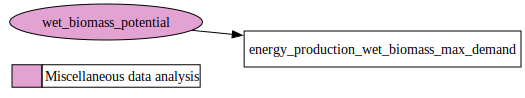

In [100]:
etlocal_key = 'energy_production_wet_biomass_max_demand'
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

In [101]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=combined_data)

In [102]:
message = "Production and potentials for bio-resources have been estimated based on research by TNO for the Netherlands (2020). The total production and potential for the Netherlands is subdivided by municipalities and provinces based on various distribution keys. See https://refman.energytransitionmodel.com/publications/2100 for more information."
print(message)
df_pipeline['commit'] = message

Production and potentials for bio-resources have been estimated based on research by TNO for the Netherlands (2020). The total production and potential for the Netherlands is subdivided by municipalities and provinces based on various distribution keys. See https://refman.energytransitionmodel.com/publications/2100 for more information.


Add data to template

In [103]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
# df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]
df_pipeline[etlocal_key] = df_pipeline[etlocal_key]*100
df_pipeline[etlocal_key]

GM0014    39.986243
GM0034    58.857011
GM0037    20.668983
GM0047    13.704253
GM0050    95.988297
            ...    
GM1979    63.648366
GM1980    10.156538
GM1982    43.055014
GM1991    21.841862
GM1992    26.165165
Name: energy_production_wet_biomass_max_demand, Length: 342, dtype: float64

Use validation function to quick-scan data

In [104]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'energy_production_wet_biomass_max_demand',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 0.01951638,
 'max_value': 5.991852324,
 'mean_value': 0.3156265585438597,
 'median_value': 0.19833550649999998}

In [105]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: energy_production_wet_biomass_max_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.02, Max=5.99, Mean=0.32
  Verification: Min=0.02, Max=5.99, Mean=0.32
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.40, Verification=0.40, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.46, Verification=0.46, Diff=0.00 (0.0%)
  Municipality GM

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM0014,0.399862,0.399862,0.0,0.0,exact_match
GM0855,0.455852,0.455852,0.0,0.0,exact_match
GM0880,0.144834,0.144834,0.0,0.0,exact_match
GM0879,0.237910,0.23791,0.0,0.0,exact_match
GM0873,0.210725,0.210725,0.0,0.0,exact_match
...,...,...,...,...,...
GM0383,0.151502,0.151502,0.0,0.0,exact_match
GM0377,0.058500,0.0585,0.0,0.0,exact_match
GM0376,0.023004,0.023004,0.0,0.0,exact_match
GM0375,0.076219,0.076219,0.0,0.0,exact_match


### Oily biomass max demand

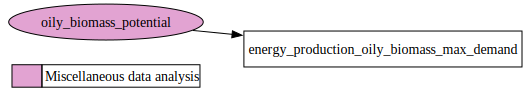

In [106]:
etlocal_key = 'energy_production_oily_biomass_max_demand'
diagram = create_dependency_diagram(etlocal_key, 
                                   yaml_dir="config/yaml_files_for_etlocal_key_calculation",
                                   save_files=False,
                                   output_dir="config")
diagram

In [107]:
df_pipeline = src.helper.generate_etlocal_key(etlocal_key,df_input_vars=combined_data)

In [108]:
message = "Production and potentials for bio-resources have been estimated based on research by TNO for the Netherlands (2020). The total production and potential for the Netherlands is subdivided by municipalities and provinces based on various distribution keys. See https://refman.energytransitionmodel.com/publications/2100 for more information."
print(message)
df_pipeline['commit'] = message

Production and potentials for bio-resources have been estimated based on research by TNO for the Netherlands (2020). The total production and potential for the Netherlands is subdivided by municipalities and provinces based on various distribution keys. See https://refman.energytransitionmodel.com/publications/2100 for more information.


Add data to template

In [109]:
df_template_local = src.helper.fill_template_with_etlocal_data(df_template_local,df_pipeline,etlocal_key=etlocal_key)
# df_template_local.loc[(slice(None), slice(None), slice(None), etlocal_key)]
df_pipeline[etlocal_key] = df_pipeline[etlocal_key]*100
df_pipeline[etlocal_key]

GM0014    12.383285
GM0034    12.631474
GM0037     1.931382
GM0047     1.670251
GM0050     1.355412
            ...    
GM1979     2.797888
GM1980     1.700690
GM1982     0.705137
GM1991     2.538519
GM1992     1.987399
Name: energy_production_oily_biomass_max_demand, Length: 342, dtype: float64

Use validation function to quick-scan data

In [110]:
src.helper.validate_template_data(df_template_local,etlocal_key)

{'key': 'energy_production_oily_biomass_max_demand',
 'total_rows': 342,
 'zero_count': 0,
 'nan_count': 0,
 'min_value': 0.000568679,
 'max_value': 0.524305465,
 'mean_value': 0.03020007803508772,
 'median_value': 0.018912216000000003}

In [111]:
src.helper.compare_template_with_verification(df_template_local,etlocal_key)


MUNICIPALITY COMPARISON FOR KEY: energy_production_oily_biomass_max_demand
  Template municipalities: 342
  Verification municipalities: 353
  Common municipalities: 338
  Missing in verification: 4
  Missing in template: 15

  MUNICIPALITIES IN TEMPLATE BUT NOT IN VERIFICATION:
     GM1980
     GM1982
     GM1991
     GM1992

  MUNICIPALITIES IN VERIFICATION BUT NOT IN TEMPLATE:
     GM0370
     GM0398
     GM0416
     GM0457
     GM0501
     GM0530
     GM0614
     GM0756
     GM0786
     GM0815
     GM0856
     GM1684
     GM1685
     GM1702
     Stap

 COMPARISON SUMMARY (338 municipalities):
  exact_match: 338 municipalities (100.0%)

 VALUE STATISTICS:
  Template:     Min=0.00, Max=0.52, Mean=0.03
  Verification: Min=0.00, Max=0.52, Mean=0.03
  Abs diff:     Min=0.00, Max=0.00, Mean=0.00

 TOP 10 LARGEST DIFFERENCES:
  Municipality GM0014: Template=0.12, Verification=0.12, Diff=0.00 (0.0%)
  Municipality GM0855: Template=0.13, Verification=0.13, Diff=0.00 (0.0%)
  Municipality G

/Users/koenvanbemmelen/work/etdataset/pipelines/src/helper.py:383: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comparison["relative_diff"] = comparison["relative_diff"].replace(


,template_value,verification_value,absolute_diff,relative_diff,status
GM0014,0.123833,0.123833,0.0,0.0,exact_match
GM0855,0.131998,0.131998,0.0,0.0,exact_match
GM0880,0.009921,0.009921,0.0,0.0,exact_match
GM0879,0.013131,0.013131,0.0,0.0,exact_match
GM0873,0.013285,0.013285,0.0,0.0,exact_match
...,...,...,...,...,...
GM0383,0.021734,0.021734,0.0,0.0,exact_match
GM0377,0.014223,0.014223,0.0,0.0,exact_match
GM0376,0.006806,0.006806,0.0,0.0,exact_match
GM0375,0.025017,0.025017,0.0,0.0,exact_match


## Export
Write the resulting filled template to a csv

In [112]:
# Write the filled template to a CSV file
path_output = Path("data", "processed", f"etlocal_template_energy_production_filled.csv")
df_template_local.to_csv(path_output, sep=sep)
